In [6]:
!pip install torch faiss-cpu faiss-gpu-cu12 tqdm numpy==1.26.4

!pip install pyarrow==14.0.1 datasets==2.14.6 transformers==4.35.2 accelerate==0.24.1

!pip -q install ipywidgets

  Using cached faiss_cpu-1.13.2-cp310-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (7.6 kB)
Using cached faiss_cpu-1.13.2-cp310-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (23.8 MB)


In [1]:
pip uninstall faiss-cpu -y

Found existing installation: faiss-cpu 1.13.2
Uninstalling faiss-cpu-1.13.2:
  Successfully uninstalled faiss-cpu-1.13.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import logging
import string
import re
import time
import matplotlib.pyplot as plt
from transformers import (
    RagTokenizer,
    RagRetriever,
    RagSequenceForGeneration,
    RagTokenForGeneration
)
from datasets import load_dataset
from tqdm import tqdm

# ==========================================
# 1. SETUP & HELPER FUNCTIONS
# ==========================================

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")
logging.getLogger("transformers").setLevel(logging.ERROR)

/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Running on: cuda


/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def calculate_em(predictions, references):
    total_em = 0
    for pred, refs in zip(predictions, references):
        if any(exact_match_score(pred, gt) for gt in refs):
            total_em += 1
    return 100 * (total_em / len(predictions))

In [3]:
# ==========================================
# 2. RAG MODEL MANAGER
# ==========================================

class RAGModelManager:
    def __init__(
        self,
        model_name,
        rag_type,  # "sequence" or "token"
        n_docs_init=5,
        use_dummy=False,
        index_name="exact",
        num_beams=1,
        max_new_tokens=16,
    ):
        self.model_name = model_name
        self.rag_type = rag_type
        self.n_docs = n_docs_init
        self.num_beams = num_beams
        self.max_new_tokens = max_new_tokens

        print(f"Loading Model: {model_name} ({rag_type})...")
        self.tokenizer = RagTokenizer.from_pretrained(model_name)
        self.retriever = RagRetriever.from_pretrained(
            model_name,
            index_name=index_name,
            use_dummy_dataset=use_dummy
        )

        if rag_type == "token":
            self.model = RagTokenForGeneration.from_pretrained(
                model_name, retriever=self.retriever
            ).to(device)
        else:
            self.model = RagSequenceForGeneration.from_pretrained(
                model_name, retriever=self.retriever
            ).to(device)

        # Initial config
        self.set_n_docs(n_docs_init)
        self.model.eval()

    def set_n_docs(self, n_docs: int):
        """Updates the number of retrieved documents (k) dynamically."""
        self.n_docs = n_docs
        self.model.config.n_docs = n_docs
        if hasattr(self.retriever, "n_docs"):
            self.retriever.n_docs = n_docs
        if hasattr(self.retriever, "config"):
            self.retriever.config.n_docs = n_docs

    def generate_answers(self, questions, batch_size=4):
        self.model.eval()
        all_answers = []
        
        # Batch processing
        for i in tqdm(range(0, len(questions), batch_size), desc=f"Generating (k={self.n_docs})"):
            batch_questions = questions[i: i + batch_size]
            
            inputs = self.tokenizer(
                batch_questions,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)

            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    n_docs=self.n_docs,
                    num_beams=self.num_beams,
                    max_new_tokens=self.max_new_tokens
                )

            batch_answers = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            all_answers.extend(batch_answers)

        return all_answers

In [4]:
# ==========================================
# 3. EXPERIMENT CONFIGURATION
# ==========================================

# Settings
USE_DUMMY = False  # Set False for real evaluation (downloads large index)
NUM_SAMPLES = None   # Use None for full dataset, or int (e.g., 100) for testing
K_VALUES = [3, 5, 7, 10, 20, 30] # The list of 'k' values to evaluate
BATCH_SIZE = 8
MAX_LOOP_TIME = None        # e.g., 30 minutes per model
MAX_ITER_TIME = 8400        # e.g., 300 for 5 minutes per k (or None to disable)


# Load Data Once
print("Loading Natural Questions Validation Set...")
dataset = load_dataset("nq_open", split="validation")
questions = []
answers = []

for row in dataset:
    questions.append(row['question'])
    answers.append(row['answer'])
    if NUM_SAMPLES and len(questions) >= NUM_SAMPLES:
        break

print(f"Loaded {len(questions)} samples.")

Loading Natural Questions Validation Set...
Loaded 3610 samples.


In [5]:
# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================

results = {
    "rag-token": {"scores": [], "k": K_VALUES},
    "rag-sequence": {"scores": [], "k": K_VALUES}
}

print("\n=== Evaluating RAG-Token ===")
rag_token_mgr = RAGModelManager(
    model_name="facebook/rag-token-nq",
    rag_type="token",
    use_dummy=USE_DUMMY
)

loop_start_time = time.time()

for k in K_VALUES:
    iter_start_time = time.time()

    # ---- Global loop timeout ----
    elapsed_loop_time = time.time() - loop_start_time
    if MAX_LOOP_TIME is not None and elapsed_loop_time > MAX_LOOP_TIME:
        print(
            f"[INTERRUPTED] Loop exceeded max time "
            f"({elapsed_loop_time:.1f}s > {MAX_LOOP_TIME}s)"
        )
        break

    print(f"\nProcessing k={k} for RAG-Token...")

    rag_token_mgr.set_n_docs(k)
    predictions = rag_token_mgr.generate_answers(
        questions, batch_size=BATCH_SIZE
    )
    score = calculate_em(predictions, answers)
    results["rag-token"]["scores"].append(score)

    iter_time = time.time() - iter_start_time
    print(
        f"RAG-Token (k={k}) EM: {score:.2f}% "
        f"| Iter time: {iter_time:.1f}s"
    )

    # ---- Per-iteration timeout (optional) ----
    if MAX_ITER_TIME is not None and iter_time > MAX_ITER_TIME:
        print(
            f"[INTERRUPTED] RAG-Token iteration exceeded "
            f"max iteration time ({iter_time:.1f}s > {MAX_ITER_TIME}s)"
        )
        break


# Free memory before next model
del rag_token_mgr
torch.cuda.empty_cache()

print("\n=== Evaluating RAG-Sequence ===")
rag_seq_mgr = RAGModelManager(
    model_name="facebook/rag-sequence-nq",
    rag_type="sequence",
    use_dummy=USE_DUMMY
)

loop_start_time = time.time()

for k in K_VALUES:
    iter_start_time = time.time()

    # ---- Global loop timeout ----
    elapsed_loop_time = time.time() - loop_start_time
    if MAX_LOOP_TIME is not None and elapsed_loop_time > MAX_LOOP_TIME:
        print(
            f"[INTERRUPTED] Loop exceeded max time "
            f"({elapsed_loop_time:.1f}s > {MAX_LOOP_TIME}s)"
        )
        break

    print(f"\nProcessing k={k} for RAG-Sequence...")

    rag_seq_mgr.set_n_docs(k)
    predictions = rag_seq_mgr.generate_answers(
        questions, batch_size=BATCH_SIZE
    )
    score = calculate_em(predictions, answers)
    results["rag-sequence"]["scores"].append(score)

    iter_time = time.time() - iter_start_time
    print(
        f"RAG-Sequence (k={k}) EM: {score:.2f}% "
        f"| Iter time: {iter_time:.1f}s"
    )

    # ---- Per-iteration timeout (optional) ----
    if MAX_ITER_TIME is not None and iter_time > MAX_ITER_TIME:
        print(
            f"[INTERRUPTED] RAG-Sequence iteration exceeded "
            f"max iteration time ({iter_time:.1f}s > {MAX_ITER_TIME}s)"
        )
        break



=== Evaluating RAG-Token ===
Loading Model: facebook/rag-token-nq (token)...


/opt/micromamba/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/micromamba/lib/python3.11/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
/opt/micromamba/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(



Processing k=3 for RAG-Token...


Generating (k=3):   0%|          | 0/452 [00:00<?, ?it/s]/opt/micromamba/lib/python3.11/site-packages/transformers/generation/utils.py:2465: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=max_length)])` instead.
  warnings.warn(
Generating (k=3): 100%|██████████| 452/452 [03:02<00:00,  2.47it/s]


RAG-Token (k=3) EM: 38.53% | Iter time: 182.9s

Processing k=5 for RAG-Token...


Generating (k=5): 100%|██████████| 452/452 [03:52<00:00,  1.94it/s]


RAG-Token (k=5) EM: 39.34% | Iter time: 232.5s

Processing k=7 for RAG-Token...


Generating (k=7): 100%|██████████| 452/452 [04:56<00:00,  1.53it/s]


RAG-Token (k=7) EM: 39.61% | Iter time: 296.4s

Processing k=10 for RAG-Token...


Generating (k=10): 100%|██████████| 452/452 [06:32<00:00,  1.15it/s]


RAG-Token (k=10) EM: 39.75% | Iter time: 392.7s

Processing k=20 for RAG-Token...


Generating (k=20): 100%|██████████| 452/452 [12:02<00:00,  1.60s/it]


RAG-Token (k=20) EM: 40.14% | Iter time: 722.7s

Processing k=30 for RAG-Token...


Generating (k=30): 100%|██████████| 452/452 [18:07<00:00,  2.41s/it]


RAG-Token (k=30) EM: 40.00% | Iter time: 1087.3s

=== Evaluating RAG-Sequence ===
Loading Model: facebook/rag-sequence-nq (sequence)...

Processing k=3 for RAG-Sequence...


Generating (k=3): 100%|██████████| 452/452 [12:15<00:00,  1.63s/it]


RAG-Sequence (k=3) EM: 36.12% | Iter time: 735.3s

Processing k=5 for RAG-Sequence...


Generating (k=5): 100%|██████████| 452/452 [19:51<00:00,  2.64s/it]


RAG-Sequence (k=5) EM: 37.48% | Iter time: 1191.8s

Processing k=7 for RAG-Sequence...


Generating (k=7): 100%|██████████| 452/452 [28:40<00:00,  3.81s/it]


RAG-Sequence (k=7) EM: 37.78% | Iter time: 1720.7s

Processing k=10 for RAG-Sequence...


Generating (k=10): 100%|██████████| 452/452 [44:41<00:00,  5.93s/it]


RAG-Sequence (k=10) EM: 38.09% | Iter time: 2681.1s

Processing k=20 for RAG-Sequence...


Generating (k=20): 100%|██████████| 452/452 [1:58:48<00:00, 15.77s/it]  


RAG-Sequence (k=20) EM: 38.39% | Iter time: 7128.5s

Processing k=30 for RAG-Sequence...


Generating (k=30): 100%|██████████| 452/452 [3:42:02<00:00, 29.48s/it]  

RAG-Sequence (k=30) EM: 38.39% | Iter time: 13322.8s
[INTERRUPTED] RAG-Sequence iteration exceeded max iteration time (13322.8s > 8400s)


Plot saved as 'k_retrieval_performance.png'


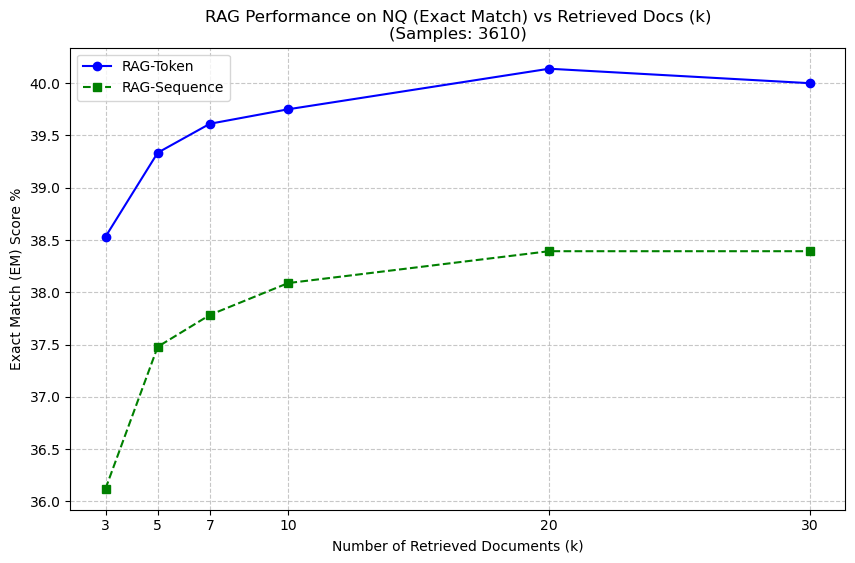

In [6]:
# ==========================================
# 5. PLOTTING RESULTS
# ==========================================

plt.figure(figsize=(10, 6))

# Plot RAG-Token
plt.plot(
    results["rag-token"]["k"], 
    results["rag-token"]["scores"], 
    marker='o', 
    label='RAG-Token', 
    linestyle='-', 
    color='blue'
)

# Plot RAG-Sequence
plt.plot(
    results["rag-sequence"]["k"], 
    results["rag-sequence"]["scores"], 
    marker='s', 
    label='RAG-Sequence', 
    linestyle='--', 
    color='green'
)

plt.title(f'RAG Performance on NQ (Exact Match) vs Retrieved Docs (k)\n(Samples: {len(questions)})')
plt.xlabel('Number of Retrieved Documents (k)')
plt.ylabel('Exact Match (EM) Score %')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(K_VALUES)  # Ensure all k values are shown on x-axis

# Save plot or show
plt.savefig("k_retrieval_performance.png")
print("Plot saved as 'k_retrieval_performance.png'")
plt.show()